In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
import numpy as np
import requests
from talib import MACD, RSI, BBANDS
from datetime import datetime, timedelta, date
from IPython.display import display, HTML
from liualgotrader.common import config
%matplotlib inline
import json
import math
from dateutil import parser
from pytz import timezone
import pytz
import sys
import iso8601
import asyncio
from pandas import DataFrame as df
from liualgotrader.analytics.analysis import (
    load_trades_by_batch_id,
    calc_batch_revenue,
    count_trades,
)
from liualgotrader.common.market_data import get_historical_data_from_poylgon_for_symbols
import nest_asyncio
nest_asyncio.apply()

In [2]:
batch_id = "6964075a-6241-41bc-aafa-89ddc9cf88a1"

In [3]:
api = tradeapi.REST(base_url="https://api.alpaca.markets")

In [4]:
trades = load_trades_by_batch_id(batch_id)

[98115]2020-10-26 21:59:40.121584:db connection pool initialized


In [5]:
trades

,trade_id,algo_run_id,symbol,operation,qty,price,indicators,client_time,tstamp,stop_price,target_price,expire_tstamp,batch_id,start_time
0,63647,5176,ADAP,sell,-201,4.97,"{""macd"": [0.017872397510568128, 0.019491209936...",2020-10-26 10:43:00-04:00,2020-10-26 19:52:40.099322,5.12,4.45,None,6964075a-6241-41bc-aafa-89ddc9cf88a1,2020-10-26 19:51:04.847032
1,63648,5176,ADAP,buy,201,4.96,"{""reason"": [""reversing direction""], ""close_5m""...",2020-10-26 11:05:00-04:00,2020-10-26 19:52:40.974292,5.12,4.45,None,6964075a-6241-41bc-aafa-89ddc9cf88a1,2020-10-26 19:51:04.847032
2,63685,5176,AMTX,sell,-234,4.26,"{""macd"": [0.052084198329549025, 0.053701178591...",2020-10-26 10:07:00-04:00,2020-10-26 19:53:33.161913,4.39,3.75,None,6964075a-6241-41bc-aafa-89ddc9cf88a1,2020-10-26 19:51:04.847032
3,63686,5176,AMTX,buy,234,4.21,"{""reason"": [""reversing direction""], ""close_5m""...",2020-10-26 10:43:00-04:00,2020-10-26 19:53:33.994658,4.39,3.75,None,6964075a-6241-41bc-aafa-89ddc9cf88a1,2020-10-26 19:51:04.847032
4,63653,5176,AP,sell,-196,5.08,"{""macd"": [0.020487447484778265, 0.020687918052...",2020-10-26 09:55:00-04:00,2020-10-26 19:52:53.796448,5.23,4.57,None,6964075a-6241-41bc-aafa-89ddc9cf88a1,2020-10-26 19:51:04.847032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,63682,5176,WWR,buy,232,4.45,"{""reason"": [""stopped""], ""close_5m"": [4.36, 4.3...",2020-10-26 10:41:00-04:00,2020-10-26 19:53:28.101645,4.42,3.83,None,6964075a-6241-41bc-aafa-89ddc9cf88a1,2020-10-26 19:51:04.847032
112,63683,5176,WWR,sell,-219,4.56,"{""macd"": [0.05243358492426786, 0.0537669265387...",2020-10-26 10:58:00-04:00,2020-10-26 19:53:28.947102,4.70,3.95,None,6964075a-6241-41bc-aafa-89ddc9cf88a1,2020-10-26 19:51:04.847032
113,63684,5176,WWR,buy,219,4.49,"{""reason"": [""reversing direction""], ""close_5m""...",2020-10-26 11:10:00-04:00,2020-10-26 19:53:29.757808,4.70,3.95,None,6964075a-6241-41bc-aafa-89ddc9cf88a1,2020-10-26 19:51:04.847032
114,63727,5176,YRD,sell,-288,3.46,"{""macd"": [0.01701623017476539, 0.0226583908712...",2020-10-26 10:52:00-04:00,2020-10-26 19:55:06.768521,3.57,3.08,None,6964075a-6241-41bc-aafa-89ddc9cf88a1,2020-10-26 19:51:04.847032


In [6]:
day_to_analyze = min(trades['client_time'].tolist())
config.market_open = day_to_analyze.replace(hour=9, minute=30, second=0, microsecond=0)

In [7]:
how_was_my_batch = pd.DataFrame()
trades["client_time"] = pd.to_datetime(trades["client_time"])
how_was_my_batch["symbol"] = trades.symbol.unique()
how_was_my_batch["revenues"] = how_was_my_batch["symbol"].apply(
    lambda x: calc_batch_revenue(x, trades, batch_id)
)
how_was_my_batch["count"] = how_was_my_batch["symbol"].apply(
    lambda x: count_trades(x, trades, batch_id)
)

In [8]:
pd.set_option('display.max_rows', how_was_my_batch.shape[0]+1)
how_was_my_batch

,symbol,revenues,count
0,ADAP,2.01,2
1,AMTX,11.70,2
2,AP,29.40,2
3,ARLP,29.90,2
4,AVXL,20.16,2
5,AWH,13.20,2
6,AXGT,0.00,2
7,CAJ,6.84,2
8,CASA,-31.65,2
9,CO,-27.71,4


In [9]:
print(f"Revenue: ${round(sum(how_was_my_batch['revenues'].tolist()), 2)}")

Revenue: $-328.06


In [10]:

minute_history = get_historical_data_from_poylgon_for_symbols(
    api,
    trades.symbol.unique().tolist(),
    day_to_analyze - timedelta(days=7),
    day_to_analyze + timedelta(days=1),
)

ADAP analysis with profit 2.01


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,998.97,998.97,sell,2020-10-26 10:43:00-04:00,4.97,-201,3.31%,,"{'macd': [0.017872397510568128, 0.019491209936670195, 0.018941048061728694, 0.015409220002530866], 'reason': ['MACD positive & above signal, MACD hist trending down, MACD trended down'], 'hist_signal': [0.006699632319898754, 0.006654755796800657, 0.004883675137487324, 0.0010814776626315963], 'macd_signal': [0.011172765190669374, 0.012836454139869538, 0.01405737292424137, 0.01432774233989927]}",4.45,5.12
1,2.01,-996.96,buy,2020-10-26 11:05:00-04:00,4.96,201,3.1%,,"{'reason': ['reversing direction'], 'close_5m': [4.92, 4.93, 4.9216, 4.94, 4.965]}",4.45,5.12


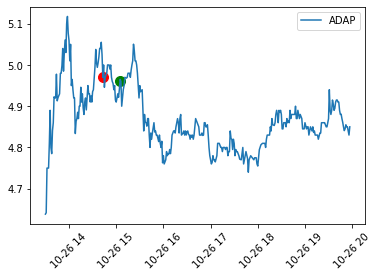

AMTX analysis with profit 11.70


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,996.84,996.84,sell,2020-10-26 10:07:00-04:00,4.26,-234,8.95%,,"{'macd': [0.052084198329549025, 0.05370117859194323, 0.05043517387962826, 0.04768198613133556], 'reason': ['MACD positive & above signal, MACD hist trending down, MACD trended down'], 'hist_signal': [0.016509412669783237, 0.014501114345741958, 0.008988087706741588, 0.004987919966759111], 'macd_signal': [0.03557478565976579, 0.039200064246201274, 0.04144708617288667, 0.04269406616457645]}",3.75,4.39
1,11.70,-985.14,buy,2020-10-26 10:43:00-04:00,4.21,234,7.67%,,"{'reason': ['reversing direction'], 'close_5m': [4.21, 4.215, 4.21, 4.185, 4.21]}",3.75,4.39


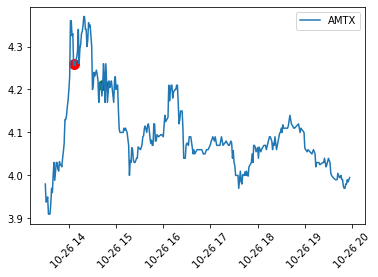

AP analysis with profit 29.40


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,995.68,995.68,sell,2020-10-26 09:55:00-04:00,5.08,-196,2.21%,,"{'macd': [0.020487447484778265, 0.020687918052464838, 0.020055974104526086, 0.017235550585294135], 'reason': ['MACD positive & above signal, MACD hist trending down, MACD trended down'], 'hist_signal': [0.011175836111708169, 0.009101045343515793, 0.006775281116461633, 0.003163886077783746], 'macd_signal': [0.009311611373070097, 0.011586872708949045, 0.013280692988064453, 0.014071664507510389]}",4.57,5.23
1,29.40,-966.28,buy,2020-10-26 11:13:00-04:00,4.93,196,-0.8%,,"{'reason': ['reversing direction'], 'close_5m': [4.84, 4.84, 4.8483, 4.885, 4.929]}",4.57,5.23


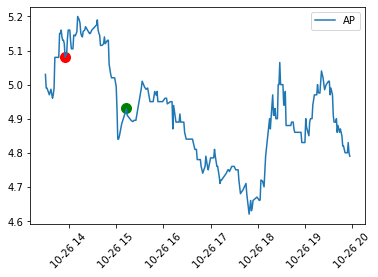

ARLP analysis with profit 29.90


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,998.66,998.66,sell,2020-10-26 10:48:00-04:00,3.34,-299,4.37%,,"{'macd': [0.01409899590691488, 0.015213426081384096, 0.014185534969524127, 0.012966586895743148], 'reason': ['MACD positive & above signal, MACD hist trending down, MACD trended down'], 'hist_signal': [0.007855364631097176, 0.0071758358444531135, 0.0049183557860745155, 0.002959526169834829], 'macd_signal': [0.006243631275817703, 0.008037590236930982, 0.009267179183449612, 0.01000706072590832]}",2.97,3.44
1,29.90,-968.76,buy,2020-10-26 11:38:00-04:00,3.24,299,1.25%,,"{'reason': ['reversing direction'], 'close_5m': [3.1772, 3.16, 3.1907, 3.1992, 3.2445]}",2.97,3.44


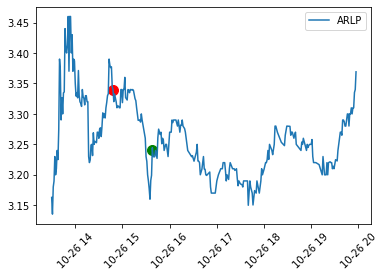

AVXL analysis with profit 20.16


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,997.92,997.92,sell,2020-10-26 10:08:00-04:00,5.94,-168,3.59%,,"{'macd': [0.04249798965217089, 0.04331129004028966, 0.041974754108430545, 0.03867907995232667], 'reason': ['MACD positive & above signal, MACD hist trending down, MACD trended down'], 'hist_signal': [0.007921762350511272, 0.006988050190904038, 0.004521211407235937, 0.0009804298009056453], 'macd_signal': [0.034576227301659615, 0.036323239849385625, 0.03745354270119461, 0.03769865015142102]}",5.27,6.12
1,20.16,-977.76,buy,2020-10-26 10:37:00-04:00,5.82,168,1.5%,,"{'reason': ['reversing direction'], 'close_5m': [5.785, 5.8, 5.7917, 5.805, 5.8151]}",5.27,6.12


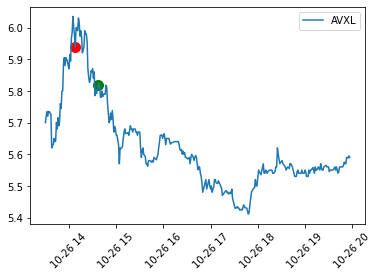

AWH analysis with profit 13.20


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,997.92,997.92,sell,2020-10-26 10:23:00-04:00,3.78,-264,0.93%,,"{'macd': [0.012650126445210574, 0.013553024896343135, 0.012522127262208027, 0.010517244336100351], 'reason': ['MACD positive & above signal, MACD hist trending down, MACD trended down'], 'hist_signal': [0.0028270593551223723, 0.002983966245003947, 0.0015624548886950702, -0.00035394242993008404], 'macd_signal': [0.009823067090088202, 0.010569058651339188, 0.010959672373512957, 0.010871186766030435]}",3.39,3.89
1,13.20,-984.72,buy,2020-10-26 10:59:00-04:00,3.73,264,-0.4%,,"{'reason': ['reversing direction'], 'close_5m': [3.72, 3.72, 3.72, 3.72, 3.73]}",3.39,3.89


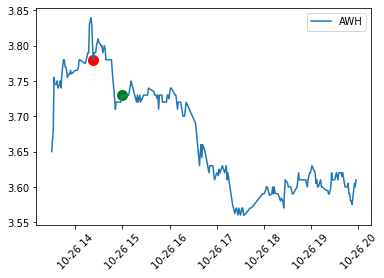

AXGT analysis with profit 0.00


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,996.96,996.96,sell,2020-10-26 10:11:00-04:00,3.72,-268,4.2%,,"{'macd': [0.020834763866314887, 0.021556429430542146, 0.020602448968504827, 0.01750840641407958], 'reason': ['MACD positive & above signal, MACD hist trending down, MACD trended down'], 'hist_signal': [0.001590643615142908, 0.0018498473434961325, 0.0007166935051670514, -0.0019018792394065558], 'macd_signal': [0.01924412025117198, 0.019706582087046013, 0.019885755463337776, 0.019410285653486136]}",3.33,3.83
1,0.00,-996.96,buy,2020-10-26 12:50:00-04:00,3.72,268,4.2%,,"{'reason': ['reversing direction'], 'close_5m': [3.735, 3.71, 3.705, 3.72, 3.7199]}",3.33,3.83


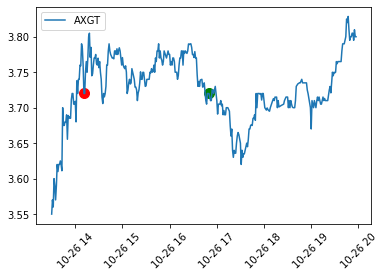

CAJ analysis with profit 6.84


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,992.37,992.37,sell,2020-10-26 10:33:00-04:00,17.41,-57,0.29%,,"{'macd': [0.023052944474219572, 0.022489026028324588, 0.02175754378440331, 0.018650446662068276], 'reason': ['MACD positive & above signal, MACD hist trending down, MACD trended down'], 'hist_signal': [0.0015866298033022468, 0.0008181690859258087, 6.934947360362487e-05, -0.0024301981189851288], 'macd_signal': [0.021466314670917325, 0.02167085694239878, 0.021688194310799686, 0.021080644781053405]}",15.66,17.93
1,6.84,-985.53,buy,2020-10-26 10:45:00-04:00,17.29,57,-0.4%,,"{'reason': ['reversing direction'], 'close_5m': [17.27, 17.27, 17.27, 17.28, 17.29]}",15.66,17.93


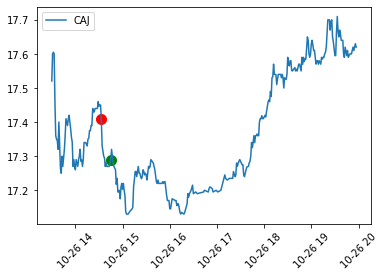

CASA analysis with profit -31.65


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,995.92,995.92,sell,2020-10-26 10:51:00-04:00,4.72,-211,3.51%,,"{'macd': [0.02768555649650395, 0.026927252665824852, 0.026246402243661926, 0.024897085002447916], 'reason': ['MACD positive & above signal, MACD hist trending down, MACD trended down'], 'hist_signal': [0.005489969151320141, 0.003785332256512834, 0.0024835854674799263, 0.0009074145810127332], 'macd_signal': [0.022195587345183808, 0.023141920409312018, 0.023762816776182, 0.023989670421435183]}",4.12,4.86
1,-31.65,-1027.57,buy,2020-10-26 14:07:00-04:00,4.87,211,6.8%,,"{'reason': ['stopped'], 'close_5m': [4.81, 4.81, 4.82, 4.84, 4.87]}",4.12,4.86


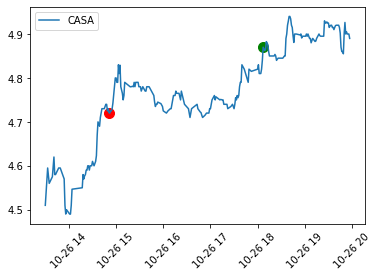

CO analysis with profit -27.71


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,997.50,997.50,sell,2020-10-26 10:00:00-04:00,3.99,-250,5.56%,,"{'macd': [0.03173962419489351, 0.031195811129693052, 0.030257829375904155, 0.028723586069368867], 'reason': ['MACD positive & above signal, MACD hist trending down, MACD trended down'], 'hist_signal': [0.00391373119213944, 0.002695934501551183, 0.0014063621982098283, -0.00010230488666036763], 'macd_signal': [0.027825893002754072, 0.02849987662814187, 0.028851467177694327, 0.028825890956029235]}",3.52,4.11
1,-35.00,-1032.50,buy,2020-10-26 10:35:00-04:00,4.13,250,9.26%,,"{'reason': ['stopped'], 'close_5m': [4.1, 4.09, 4.09, 4.09, 4.13]}",3.52,4.11
2,963.73,998.73,sell,2020-10-26 10:38:00-04:00,4.11,-243,8.73%,,"{'macd': [0.013493429814311675, 0.014544497758815389, 0.01440059618623657, 0.013841704101288599], 'reason': ['MACD positive & above signal, MACD hist trending down, MACD trended down'], 'hist_signal': [0.0005830086584018498, 0.0013072612823244508, 0.0009306877677965047, 0.0002974365462788276], 'macd_signal': [0.012910421155909825, 0.013237236476490938, 0.013469908418440065, 0.013544267555009771]}",3.59,4.23
3,-27.71,-991.44,buy,2020-10-26 11:15:00-04:00,4.08,243,7.94%,,"{'reason': ['reversing direction'], 'close_5m': [4.055, 4.04, 4.0312, 4.03, 4.08]}",3.59,4.23


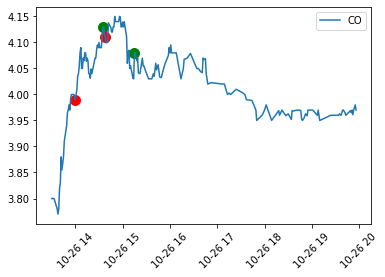

CODX analysis with profit -74.70


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,989.88,989.88,sell,2020-10-26 09:48:00-04:00,13.56,-73,5.03%,,"{'macd': [0.16541528081765833, 0.1713839777427637, 0.17024031329813383, 0.16713823303870612], 'reason': ['MACD positive & above signal, MACD hist trending down, MACD trended down'], 'hist_signal': [0.02676854970537801, 0.026189797304386697, 0.020036906287805467, 0.013547860822702207], 'macd_signal': [0.13864673111228032, 0.145194180438377, 0.15020340701032836, 0.1535903722160039]}",11.92,13.97
1,-39.42,-1029.30,buy,2020-10-26 09:58:00-04:00,14.10,73,9.22%,,"{'reason': ['stopped'], 'close_5m': [13.7799, 13.771, 13.86, 13.8318, 14.1007]}",11.92,13.97
2,946.98,986.40,sell,2020-10-26 10:49:00-04:00,13.70,-72,6.12%,,"{'macd': [0.03686171773305347, 0.03621201114579975, 0.0357549409330602, 0.033375990885039286], 'reason': ['MACD positive & above signal, MACD hist trending down, MACD trended down'], 'hist_signal': [0.005637487724206563, 0.003990224909562273, 0.002826523757458177, 0.0003580589675498125], 'macd_signal': [0.031224230008846904, 0.032221786236237476, 0.03292841717560202, 0.033017931917489474]}",12.21,14.11
3,-74.70,-1021.68,buy,2020-10-26 11:20:00-04:00,14.19,72,9.91%,,"{'reason': ['stopped'], 'close_5m': [13.96, 13.997, 14.08, 14.08, 14.19]}",12.21,14.11


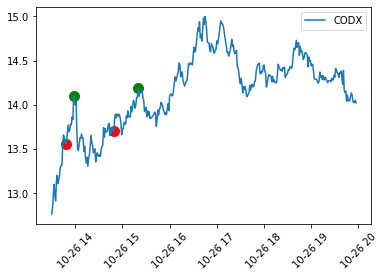

DRV analysis with profit 2.13


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,994.71,994.71,sell,2020-10-26 09:47:00-04:00,14.01,-71,0.5%,,"{'macd': [0.09054756464878011, 0.09016307239228816, 0.09012109047304406, 0.0868400514389176], 'reason': ['MACD positive & above signal, MACD hist trending down, MACD trended down'], 'hist_signal': [0.013792252050905923, 0.010726207835531174, 0.008547380733029658, 0.004213073359122549], 'macd_signal': [0.07675531259787419, 0.07943686455675698, 0.0815737097400144, 0.08262697807979505]}",12.52,14.43
1,2.13,-992.58,buy,2020-10-26 14:53:00-04:00,13.98,71,0.29%,,"{'reason': ['MACD crossing above signal'], 'close_5m': [13.97, 13.98, 13.99, 13.9699, 13.9801]}",12.52,14.43


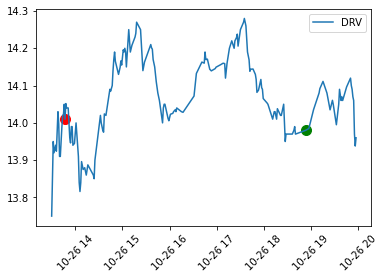

DXD analysis with profit -30.08


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,990.72,990.72,sell,2020-10-26 10:40:00-04:00,15.48,-64,1.24%,,"{'macd': [0.02602666788744834, 0.025352995973577208, 0.024446849079994948, 0.02243106125278871], 'reason': ['MACD positive & above signal, MACD hist trending down, MACD trended down'], 'hist_signal': [0.005618030403363634, 0.003955486791594, 0.0024394719184093923, 0.0003389472729625233], 'macd_signal': [0.020408637484084707, 0.02139750918198321, 0.022007377161585556, 0.022092113979826185]}",13.84,15.94
1,-30.08,-1020.80,buy,2020-10-26 13:30:00-04:00,15.95,64,4.32%,,"{'reason': ['stopped'], 'close_5m': [15.9201, 15.909, 15.91, 15.9116, 15.95]}",13.84,15.94


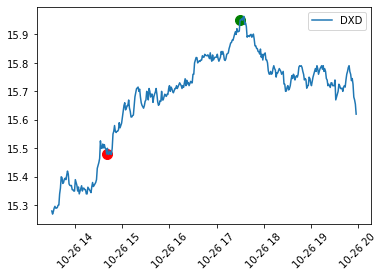

EBON analysis with profit 29.58


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,995.52,995.52,sell,2020-10-26 09:55:00-04:00,9.76,-102,3.39%,,"{'macd': [0.057781703796299766, 0.05748031190754688, 0.0570755869045243, 0.054460533825487545], 'reason': ['MACD positive & above signal, MACD hist trending down, MACD trended down'], 'hist_signal': [0.002088215022366356, 0.001429458506890774, 0.000819786803094559, -0.0014362130207537585], 'macd_signal': [0.05569348877393341, 0.0560508534006561, 0.05625580010142974, 0.0558967468462413]}",8.69,10.05
1,29.58,-965.94,buy,2020-10-26 12:14:00-04:00,9.47,102,0.32%,,"{'reason': ['reversing direction'], 'close_5m': [9.45, 9.42, 9.41, 9.49, 9.47]}",8.69,10.05


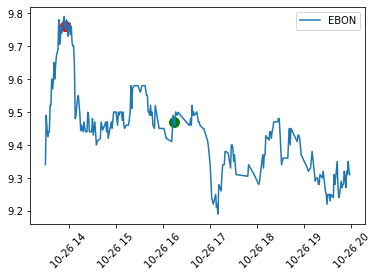

FAZ analysis with profit -10.36


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,993.08,993.08,sell,2020-10-26 10:40:00-04:00,13.42,-74,1.82%,,"{'macd': [0.029212859047826, 0.029367868553743293, 0.02918517636934581, 0.028144310039044385], 'reason': ['MACD positive & above signal, MACD hist trending down, MACD trended down'], 'hist_signal': [0.0055637724723737805, 0.0045750255826328586, 0.003513866718588301, 0.0019784003106294995], 'macd_signal': [0.02364908657545222, 0.024792842971110434, 0.02567130965075751, 0.026165909728414885]}",11.93,13.82
1,-10.36,-1003.44,buy,2020-10-26 15:50:00-04:00,13.56,74,2.88%,,{'liquidate': 1},None,None


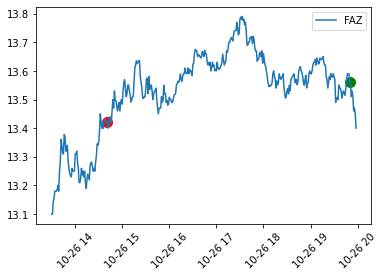

FOSL analysis with profit -28.62


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,996.98,996.98,sell,2020-10-26 10:09:00-04:00,6.31,-158,5.61%,,"{'macd': [0.03883452872639914, 0.04145462358368324, 0.04087996212723333, 0.03953762901665936], 'reason': ['MACD positive & above signal, MACD hist trending down, MACD trended down'], 'hist_signal': [0.007244079673826828, 0.007891339624888735, 0.00585334253475106, 0.003608807539341674], 'macd_signal': [0.031590449052572314, 0.0335632839587945, 0.035026619592482267, 0.035928821477317685]}",5.49,6.50
1,-33.18,-1030.16,buy,2020-10-26 10:34:00-04:00,6.52,158,9.12%,,"{'reason': ['stopped'], 'close_5m': [6.485, 6.4701, 6.47, 6.5, 6.52]}",5.49,6.50
2,962.42,995.60,sell,2020-10-26 10:41:00-04:00,6.55,-152,9.62%,,"{'macd': [0.032758950215797, 0.03361048290213464, 0.033058294308344394, 0.0321986889845034], 'reason': ['MACD positive & above signal, MACD hist trending down, MACD trended down'], 'hist_signal': [8.026127947339395e-05, 0.0007454351726488284, 0.00015459726308686417, -0.0005640064486033061], 'macd_signal': [0.032678688936323606, 0.03286504772948581, 0.03290369704525753, 0.032762695433106705]}",5.62,6.75
3,-28.62,-991.04,buy,2020-10-26 11:11:00-04:00,6.52,152,9.12%,,"{'reason': ['reversing direction'], 'close_5m': [6.4887, 6.49, 6.5003, 6.48, 6.52]}",5.62,6.75


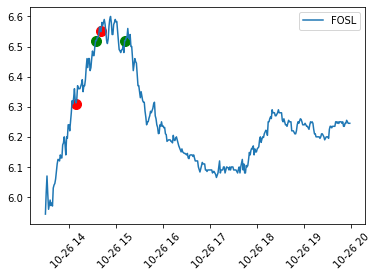

FUBO analysis with profit 31.99


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,989.74,989.74,sell,2020-10-26 09:49:00-04:00,13.94,-71,2.88%,,"{'macd': [0.09176348811433144, 0.0881877321712583, 0.08451587387573056, 0.07885318073797087], 'reason': ['MACD positive & above signal, MACD hist trending down, MACD trended down'], 'hist_signal': [0.013348729025921574, 0.007818378466278753, 0.003317216136600812, -0.0018763816009270962], 'macd_signal': [0.07841475908840986, 0.08036935370497955, 0.08119865773912975, 0.08072956233889797]}",12.35,14.36
1,30.53,-959.21,buy,2020-10-26 10:16:00-04:00,13.51,71,-0.3%,,"{'reason': ['reversing direction'], 'close_5m': [13.4869, 13.47, 13.498, 13.5, 13.51]}",12.35,14.36
2,1024.06,993.53,sell,2020-10-26 10:49:00-04:00,13.61,-73,0.44%,,"{'macd': [0.03701429693896152, 0.03509879947185901, 0.032963362491365444, 0.030351809487196846], 'reason': ['MACD positive & above signal, MACD hist trending down, MACD trended down'], 'hist_signal': [0.015494584868854196, 0.010863269921401346, 0.006982266352726224, 0.003496570678846102], 'macd_signal': [0.021519712070107326, 0.024235529550457664, 0.02598109613863922, 0.026855238808350744]}",12.29,14.02
3,31.99,-992.07,buy,2020-10-26 11:02:00-04:00,13.59,73,0.3%,,"{'reason': ['reversing direction'], 'close_5m': [13.54, 13.4832, 13.475, 13.59, 13.59]}",12.29,14.02


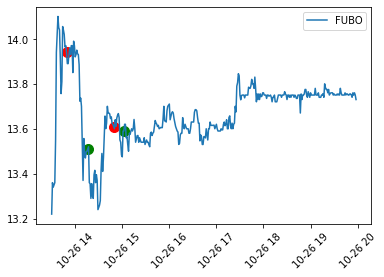

GLP analysis with profit 5.28


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,991.98,991.98,sell,2020-10-26 10:08:00-04:00,15.03,-66,3.82%,,"{'macd': [0.10787286338258006, 0.11252707798226247, 0.11105598444977893, 0.10379206761342985], 'reason': ['MACD positive & above signal, MACD hist trending down, MACD trended down'], 'hist_signal': [0.02142545562771586, 0.020863736181918613, 0.015514114119548061, 0.006600157826559178], 'macd_signal': [0.0864474077548642, 0.09166334180034386, 0.09554187033023087, 0.09719190978687067]}",13.24,15.48
1,5.28,-986.70,buy,2020-10-26 12:29:00-04:00,14.95,66,3.27%,,"{'reason': ['reversing direction'], 'close_5m': [14.945, 14.945, 14.92, 14.9499, 14.95]}",13.24,15.48


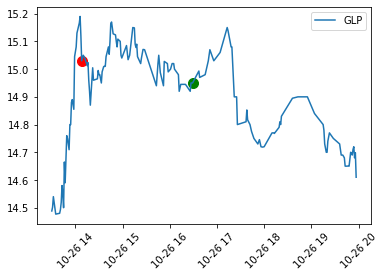

HIBS analysis with profit -30.10


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,999.75,999.75,sell,2020-10-26 10:54:00-04:00,4.65,-215,2.2%,,"{'macd': [0.010786823610682283, 0.010999835332426322, 0.009989197254142823, 0.009591437748284193], 'reason': ['MACD positive & above signal, MACD hist trending down, MACD trended down'], 'hist_signal': [0.0012059863203212357, 0.0011351984336522188, 9.96482842949755e-05, -0.00023848897725092452], 'macd_signal': [0.009580837290361048, 0.009864636898774103, 0.009889548969847848, 0.009829926725535117]}",4.11,4.79
1,-30.10,-1029.85,buy,2020-10-26 13:13:00-04:00,4.79,215,5.27%,,"{'reason': ['stopped'], 'close_5m': [4.78, 4.775, 4.779, 4.77, 4.79]}",4.11,4.79


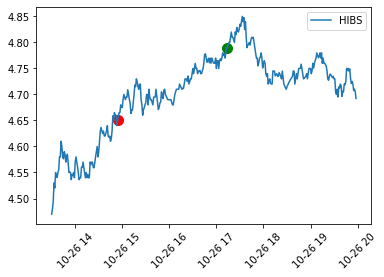

HX analysis with profit 8.22


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,998.73,998.73,sell,2020-10-26 10:56:00-04:00,2.43,-411,8.48%,,"{'macd': [0.02332412071727985, 0.023640777342719854, 0.02332075942302758, 0.020960735596994073], 'reason': ['MACD positive & above signal, MACD hist trending down, MACD trended down'], 'hist_signal': [0.005560844214509329, 0.004702000671959465, 0.0035055862018137547, 0.0009164499006241965], 'macd_signal': [0.01776327650277052, 0.01893877667076039, 0.019815173221213827, 0.020044285696369877]}",2.13,2.50
1,8.22,-990.51,buy,2020-10-26 11:21:00-04:00,2.41,411,7.59%,,"{'reason': ['reversing direction'], 'close_5m': [2.3786, 2.37, 2.3601, 2.385, 2.4099]}",2.13,2.50


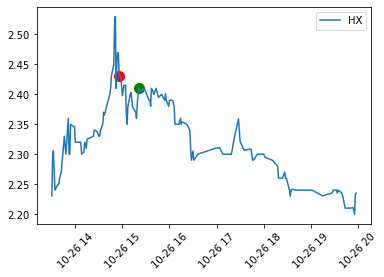

JMIA analysis with profit 45.36


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,996.84,996.84,sell,2020-10-26 10:21:00-04:00,18.46,-54,-2.97%,,"{'macd': [0.003997269621592636, 0.008283856669471845, 0.0067891990876951525, 0.0026792165682891778], 'reason': ['MACD positive & above signal, MACD hist trending down, MACD trended down'], 'hist_signal': [-0.0005515946919463334, 0.0029879938847463, 0.001194669042375686, -0.0023322507816242307], 'macd_signal': [0.00454886431353897, 0.005295862784725545, 0.005594530045319466, 0.0050114673499134085]}",16.82,19.02
1,9.18,-987.66,buy,2020-10-26 10:34:00-04:00,18.29,54,-3.86%,,"{'reason': ['reversing direction'], 'close_5m': [18.27, 18.26, 18.1309, 18.1934, 18.29]}",16.82,19.02
2,1002.24,993.06,sell,2020-10-26 10:47:00-04:00,18.39,-54,-3.34%,,"{'macd': [0.013287702278471869, 0.012952828170814001, 0.012793798630159614, 0.010269960044844595], 'reason': ['MACD positive & above signal, MACD hist trending down, MACD trended down'], 'hist_signal': [0.026863408233795634, 0.021222827300910213, 0.01685103820820466, 0.011461759698311712], 'macd_signal': [-0.013575705955323765, -0.008269999130096212, -0.0040572395780450465, -0.001191799653467118]}",16.77,18.94
3,45.36,-956.88,buy,2020-10-26 11:02:00-04:00,17.72,54,-6.86%,,"{'reason': ['reversing direction'], 'close_5m': [17.72, 17.79, 17.54, 17.75, 17.72]}",16.77,18.94


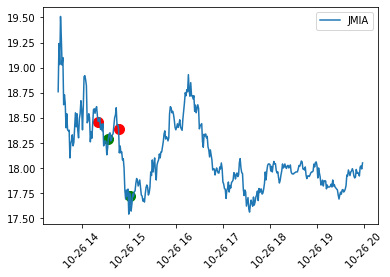

LAC analysis with profit 0.91


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,999.18,999.18,sell,2020-10-26 09:57:00-04:00,10.98,-91,4.57%,,"{'macd': [0.07593181451672137, 0.07645359223311843, 0.07157116458052926, 0.06542419284370204], 'reason': ['MACD positive & above signal, MACD hist trending down, MACD trended down'], 'hist_signal': [0.0163262668268659, 0.013478435634610361, 0.006876806385616954, 0.0005838677190317942], 'macd_signal': [0.05960554768985547, 0.06297515659850807, 0.0646943581949123, 0.06484032512467025]}",9.77,11.31
1,0.91,-998.27,buy,2020-10-26 10:18:00-04:00,10.97,91,4.48%,,"{'reason': ['reversing direction'], 'close_5m': [10.9, 10.9223, 10.94, 10.92, 10.972]}",9.77,11.31


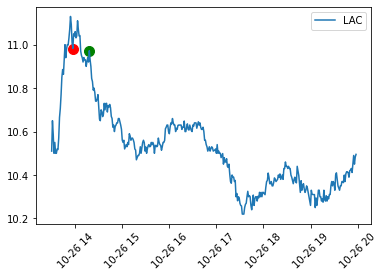

LAIX analysis with profit 16.12


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,999.44,999.44,sell,2020-10-26 10:05:00-04:00,2.48,-403,4.94%,,"{'macd': [0.019428629504745665, 0.0193560606298675, 0.019048136043860353, 0.01752185537886941], 'reason': ['MACD positive & above signal, MACD hist trending down, MACD trended down'], 'hist_signal': [0.001660804466001753, 0.001270588472898869, 0.0007701311095133778, -0.0006049196443820501], 'macd_signal': [0.017767825038743912, 0.01808547215696863, 0.018278004934346975, 0.01812677502325146]}",2.20,2.55
1,16.12,-983.32,buy,2020-10-26 11:07:00-04:00,2.44,403,3.25%,,"{'reason': ['reversing direction'], 'close_5m': [2.41, 2.42, 2.4299, 2.4299, 2.4422]}",2.20,2.55


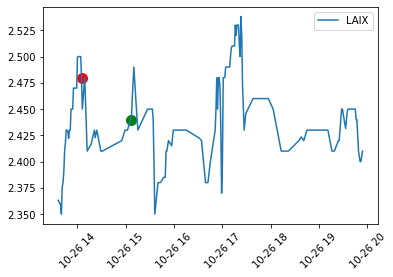

LI analysis with profit 19.24


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,989.56,989.56,sell,2020-10-26 10:11:00-04:00,19.03,-52,2.81%,,"{'macd': [0.0878703041714779, 0.08674523049177552, 0.08474198826743518, 0.07984151395928407], 'reason': ['MACD positive & above signal, MACD hist trending down, MACD trended down'], 'hist_signal': [0.017724493022165805, 0.013279535473970733, 0.009021034599704311, 0.0032964482332425715], 'macd_signal': [0.07014581114931209, 0.07346569501780478, 0.07572095366773086, 0.0765450657260415]}",16.87,19.60
1,3.64,-985.92,buy,2020-10-26 10:30:00-04:00,18.96,52,2.43%,,"{'reason': ['reversing direction'], 'close_5m': [18.9, 18.9, 18.9, 18.9, 18.96]}",16.87,19.60
2,996.32,992.68,sell,2020-10-26 10:50:00-04:00,19.09,-52,3.13%,,"{'macd': [0.04069254128943811, 0.043661317697829105, 0.04125177570829308, 0.03779951213581967], 'reason': ['MACD positive & above signal, MACD hist trending down, MACD trended down'], 'hist_signal': [0.018195552928171786, 0.016931463469250223, 0.01161753718377136, 0.006532218889038356], 'macd_signal': [0.022496988361266325, 0.026729854228578882, 0.02963423852452172, 0.03126729324678131]}",16.95,19.66
3,19.24,-977.08,buy,2020-10-26 11:11:00-04:00,18.79,52,1.51%,,"{'reason': ['reversing direction'], 'close_5m': [18.75, 18.715, 18.68, 18.665, 18.79]}",16.95,19.66


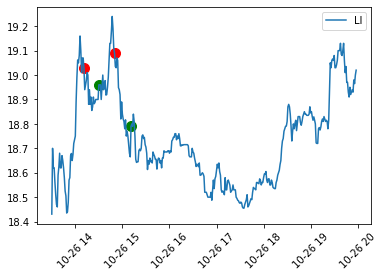

MARA analysis with profit 0.00


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,996.16,996.16,sell,2020-10-26 10:22:00-04:00,2.83,-352,-2.41%,,"{'macd': [0.001098817920454298, 0.0015089557151402033, 0.0012894662601530271, 0.0007328580321090961], 'reason': ['MACD positive & above signal, MACD hist trending down, MACD trended down'], 'hist_signal': [0.00020139240550254376, 0.0004892241601507593, 0.0002157877641308665, -0.0002726563711304517], 'macd_signal': [0.0008974255149517543, 0.001019731554989444, 0.0010736784960221606, 0.0010055144032395478]}",2.56,2.92
1,0.00,-996.16,buy,2020-10-26 10:38:00-04:00,2.83,352,-2.41%,,"{'reason': ['reversing direction'], 'close_5m': [2.7896, 2.7818, 2.78, 2.8108, 2.8299]}",2.56,2.92


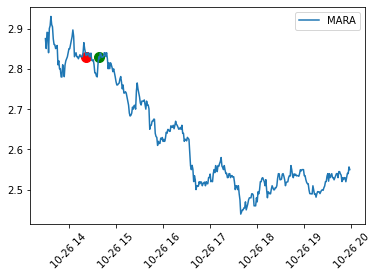

NK analysis with profit -5.60


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,996.80,996.80,sell,2020-10-26 10:31:00-04:00,8.90,-112,0.58%,,"{'macd': [0.01578356246022672, 0.015466049918474667, 0.015220377159726795, 0.014628679202784767], 'reason': ['MACD positive & above signal, MACD hist trending down, MACD trended down'], 'hist_signal': [0.015020866078022327, 0.01176268282901622, 0.009213608056214679, 0.0068975280794181205], 'macd_signal': [0.0007626963822043912, 0.0037033670894584462, 0.006006769103512116, 0.007731151123366646]}",7.98,9.17
1,-5.60,-1002.40,buy,2020-10-26 15:50:00-04:00,8.95,112,1.14%,,{'liquidate': 1},None,None


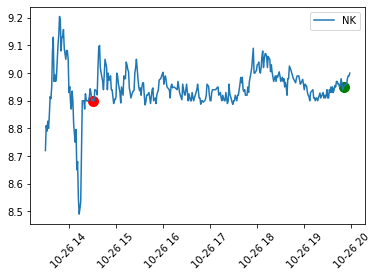

OSUR analysis with profit 17.01


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,990.99,990.99,sell,2020-10-26 10:26:00-04:00,15.73,-63,4.52%,,"{'macd': [0.10119993524583215, 0.1020078844425214, 0.09741657362899936, 0.09179455775315049], 'reason': ['MACD positive & above signal, MACD hist trending down, MACD trended down'], 'hist_signal': [0.009519084052484944, 0.00826162659933935, 0.0029362526286538515, -0.0021486105977560205], 'macd_signal': [0.09168085119334721, 0.09374625784318205, 0.09448032100034551, 0.0939431683509065]}",13.98,16.20
1,17.01,-973.98,buy,2020-10-26 10:42:00-04:00,15.46,63,2.72%,,"{'reason': ['reversing direction'], 'close_5m': [15.46, 15.46, 15.44, 15.455, 15.46]}",13.98,16.20


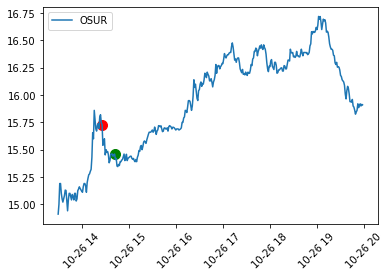

PEIX analysis with profit 11.88


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,993.60,993.60,sell,2020-10-26 10:03:00-04:00,9.20,-108,6.72%,,"{'macd': [0.07400176381350221, 0.07255013556546608, 0.07048198192328847, 0.06535768061869263], 'reason': ['MACD positive & above signal, MACD hist trending down, MACD trended down'], 'hist_signal': [0.008018726213623817, 0.00525367837247015, 0.002548419784234035, -0.0020607052162894546], 'macd_signal': [0.06598303759987839, 0.06729645719299593, 0.06793356213905444, 0.06741838583498208]}",8.03,9.48
1,11.88,-981.72,buy,2020-10-26 10:37:00-04:00,9.09,108,5.44%,,"{'reason': ['reversing direction'], 'close_5m': [9.0, 9.07, 9.05, 9.01, 9.09]}",8.03,9.48


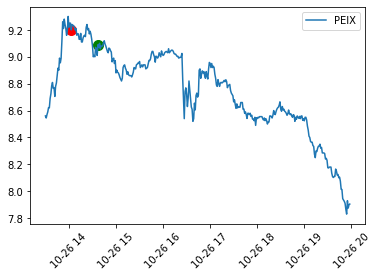

PRTS analysis with profit 14.80


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,999.74,999.74,sell,2020-10-26 10:49:00-04:00,13.51,-74,-2.53%,,"{'macd': [0.004393007616746658, 0.00635834428917903, 0.0036513554067987286, 0.00045563218147925966], 'reason': ['MACD positive & above signal, MACD hist trending down, MACD trended down'], 'hist_signal': [0.020149707620380784, 0.017692035434250526, 0.011988037241496179, 0.007033851212941368], 'macd_signal': [-0.015756700003634126, -0.011333691145071495, -0.00833668183469745, -0.006578219031462109]}",12.40,13.92
1,14.80,-984.94,buy,2020-10-26 11:08:00-04:00,13.31,74,-3.98%,,"{'reason': ['reversing direction'], 'close_5m': [13.22, 13.23, 13.24, 13.225, 13.3073]}",12.40,13.92


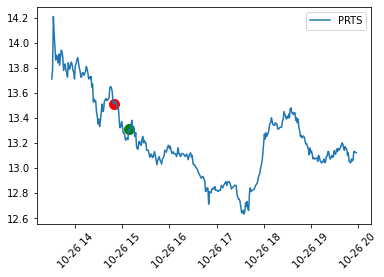

SCO analysis with profit -10.08


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,986.72,986.72,sell,2020-10-26 09:48:00-04:00,17.62,-56,1.03%,,"{'macd': [0.09597428886163328, 0.09379140636222871, 0.0915269342021432, 0.08665167103581695], 'reason': ['MACD positive & above signal, MACD hist trending down, MACD trended down'], 'hist_signal': [0.0068323449696347655, 0.0037195699761841533, 0.0011640782528789112, -0.002968947930757873], 'macd_signal': [0.08914194389199852, 0.09007183638604456, 0.09036285594926428, 0.08962061896657482]}",15.78,18.15
1,-10.08,-996.80,buy,2020-10-26 15:50:00-04:00,17.80,56,2.06%,,{'liquidate': 1},None,None


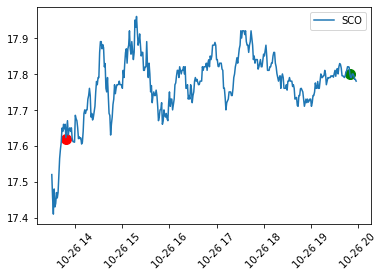

SDOW analysis with profit -30.80


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,996.80,996.80,sell,2020-10-26 10:39:00-04:00,17.80,-56,2.01%,,"{'macd': [0.04328642827184126, 0.04343833319778767, 0.042473085955698764, 0.040597918157242674], 'reason': ['MACD positive & above signal, MACD hist trending down, MACD trended down'], 'hist_signal': [0.01088103823778453, 0.00882635453098475, 0.0062888858311166765, 0.003530974426128472], 'macd_signal': [0.03240539003405673, 0.03461197866680292, 0.03618420012458209, 0.0370669437311142]}",15.84,18.33
1,-30.80,-1027.60,buy,2020-10-26 12:35:00-04:00,18.35,56,5.16%,,"{'reason': ['stopped'], 'close_5m': [18.2545, 18.31, 18.3299, 18.3283, 18.3486]}",15.84,18.33


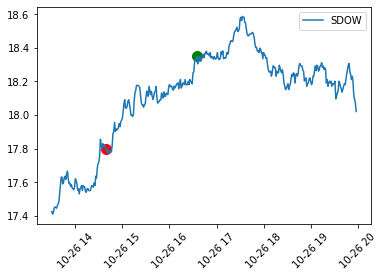

SELB analysis with profit -42.15


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,997.55,997.55,sell,2020-10-26 09:55:00-04:00,3.55,-281,8.37%,,"{'macd': [0.07657659144176021, 0.07856908047001498, 0.07686233061579761, 0.07469522253957894], 'reason': ['MACD positive & above signal, MACD hist trending down, MACD trended down'], 'hist_signal': [0.004229225233967043, 0.004977371409777456, 0.0026164972444480683, 0.00035951133458352047], 'macd_signal': [0.07234736620779317, 0.07359170906023753, 0.07424583337134955, 0.07433571120499542]}",3.07,3.65
1,-42.15,-1039.70,buy,2020-10-26 10:05:00-04:00,3.70,281,12.95%,,"{'reason': ['stopped'], 'close_5m': [3.64, 3.6081, 3.5669, 3.61, 3.7]}",3.07,3.65


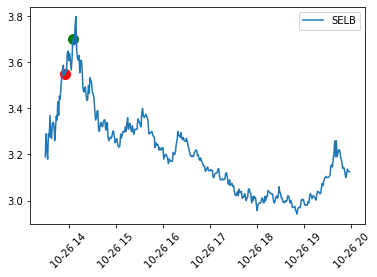

SGLB analysis with profit 4.00


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,1000.00,1000.00,sell,2020-10-26 09:49:00-04:00,2.50,-400,-0.23%,,"{'macd': [0.015305378866752761, 0.015197509796078812, 0.01365894286053937, 0.010578774561930349], 'reason': ['MACD positive & above signal, MACD hist trending down, MACD trended down'], 'hist_signal': [0.0023193632911826887, 0.0017691953764069918, 0.00018450275269403862, -0.0023165324367319853], 'macd_signal': [0.012986015575570073, 0.01342831441967182, 0.01347444010784533, 0.012895306998662334]}",2.26,2.58
1,4.00,-996.00,buy,2020-10-26 10:23:00-04:00,2.49,400,-0.63%,,"{'reason': ['reversing direction'], 'close_5m': [2.4846, 2.47, 2.4709, 2.48, 2.49]}",2.26,2.58


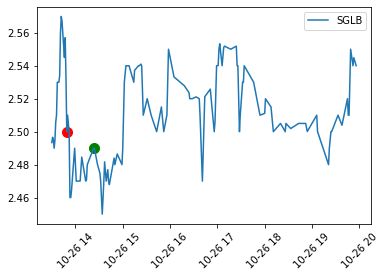

SMMC analysis with profit 10.20


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,993.65,993.65,sell,2020-10-26 10:14:00-04:00,11.69,-85,-0.51%,,"{'macd': [0.03403946048946693, 0.03313279238619238, 0.03095704071628802, 0.028340129795370927], 'reason': ['MACD positive & above signal, MACD hist trending down, MACD trended down'], 'hist_signal': [0.008269053669997275, 0.0058899084533781745, 0.0029713254267790534, 0.0002835316046895693], 'macd_signal': [0.025770406819469658, 0.027242883932814203, 0.027985715289508967, 0.028056598190681358]}",10.41,12.04
1,10.20,-983.45,buy,2020-10-26 10:26:00-04:00,11.57,85,-1.53%,,"{'reason': ['reversing direction'], 'close_5m': [11.555, 11.53, 11.53, 11.53, 11.57]}",10.41,12.04


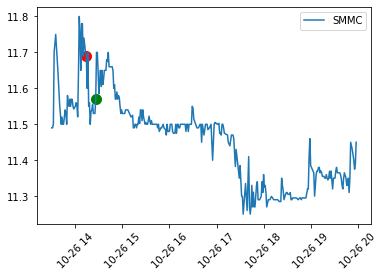

SPPI analysis with profit -12.08


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,996.48,996.48,sell,2020-10-26 09:58:00-04:00,3.46,-288,0.03%,,"{'macd': [0.012436453394287561, 0.012830577486575123, 0.01166716018853231, 0.009570118655141346], 'reason': ['MACD positive & above signal, MACD hist trending down, MACD trended down'], 'hist_signal': [0.003580335648871332, 0.003179567792927116, 0.0016129203959074426, -0.0003872969099868173], 'macd_signal': [0.008856117745416229, 0.009651009693648007, 0.010054239792624868, 0.009957415565128164]}",3.10,3.57
1,-31.68,-1028.16,buy,2020-10-26 10:04:00-04:00,3.57,288,3.21%,,"{'reason': ['stopped'], 'close_5m': [3.47, 3.5, 3.525, 3.5383, 3.57]}",3.10,3.57
2,965.12,996.80,sell,2020-10-26 10:15:00-04:00,3.56,-280,2.92%,,"{'macd': [0.015860302783754054, 0.01587487290645484, 0.015420318808475386, 0.014606116669680258], 'reason': ['MACD positive & above signal, MACD hist trending down, MACD trended down'], 'hist_signal': [0.0013258649787394917, 0.001072348081152221, 0.0004942351865382145, -0.00025597356180553053], 'macd_signal': [0.014534437805014563, 0.014802524825302619, 0.014926083621937172, 0.014862090231485789]}",3.13,3.67
3,-12.08,-977.20,buy,2020-10-26 10:33:00-04:00,3.49,280,0.9%,,"{'reason': ['reversing direction'], 'close_5m': [3.48, 3.475, 3.475, 3.48, 3.49]}",3.13,3.67


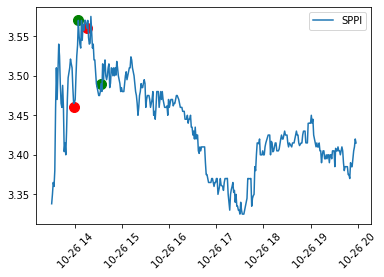

SPXS analysis with profit -31.45


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,997.15,997.15,sell,2020-10-26 10:39:00-04:00,5.39,-185,1.16%,,"{'macd': [0.013367622821378156, 0.013246768108473361, 0.01298055965545064, 0.012085065280945884], 'reason': ['MACD positive & above signal, MACD hist trending down, MACD trended down'], 'hist_signal': [0.003687248573702232, 0.002853115088637951, 0.002069525308492184, 0.0009392247471899408], 'macd_signal': [0.009680374247675923, 0.01039365301983541, 0.010911034346958457, 0.011145840533755943]}",4.81,5.55
1,-31.45,-1028.60,buy,2020-10-26 12:45:00-04:00,5.56,185,4.35%,,"{'reason': ['stopped'], 'close_5m': [5.54, 5.5407, 5.5499, 5.545, 5.5568]}",4.81,5.55


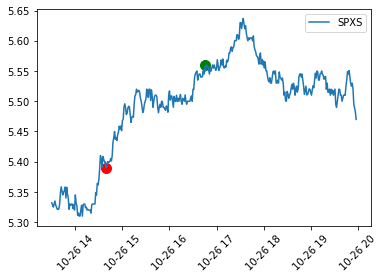

SPXU analysis with profit -30.50


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,993.08,993.08,sell,2020-10-26 10:39:00-04:00,8.14,-122,1.12%,,"{'macd': [0.019690241397016806, 0.01971752973892471, 0.019067137151594693, 0.01786595932832924], 'reason': ['MACD positive & above signal, MACD hist trending down, MACD trended down'], 'hist_signal': [0.004952093324149236, 0.0039835053328457146, 0.002666490196412557, 0.001172249898517684], 'macd_signal': [0.01473814807286757, 0.015734024406078996, 0.016400646955182136, 0.016693709429811555]}",7.28,8.39
1,-30.50,-1023.58,buy,2020-10-26 12:46:00-04:00,8.39,122,4.22%,,"{'reason': ['stopped'], 'close_5m': [8.3718, 8.3782, 8.3719, 8.381, 8.39]}",7.28,8.39


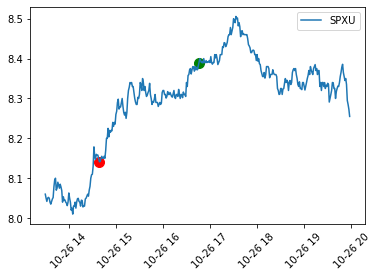

SRTY analysis with profit -31.68


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,993.60,993.60,sell,2020-10-26 10:38:00-04:00,6.90,-144,1.34%,,"{'macd': [0.011139178159417007, 0.011907363691608275, 0.011873386655762097, 0.011173230697235859], 'reason': ['MACD positive & above signal, MACD hist trending down, MACD trended down'], 'hist_signal': [0.0023634741132178387, 0.0025053277163272856, 0.001977080544384887, 0.0010215396686869185], 'macd_signal': [0.008775704046199168, 0.00940203597528099, 0.00989630611137721, 0.01015169102854894]}",6.16,7.11
1,-31.68,-1025.28,buy,2020-10-26 12:54:00-04:00,7.12,144,4.57%,,"{'reason': ['stopped'], 'close_5m': [7.105, 7.1, 7.1067, 7.1, 7.1199]}",6.16,7.11


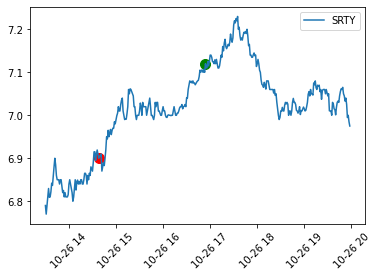

SSNT analysis with profit -38.17


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,999.36,999.36,sell,2020-10-26 10:08:00-04:00,2.88,-347,2.49%,,"{'macd': [0.01502441856602621, 0.01572048101702217, 0.014500263692901694, 0.011802688327445576], 'reason': ['MACD positive & above signal, MACD hist trending down, MACD trended down'], 'hist_signal': [0.004697975974387477, 0.00431523074030675, 0.002476010732949018, -0.00017725170600567906], 'macd_signal': [0.010326442591638733, 0.01140525027671542, 0.012024252959952676, 0.011979940033451255]}",2.63,2.97
1,-38.17,-1037.53,buy,2020-10-26 11:30:00-04:00,2.99,347,6.41%,,"{'reason': ['stopped'], 'close_5m': [2.9, 2.885, 2.9188, 2.94, 2.9852]}",2.63,2.97


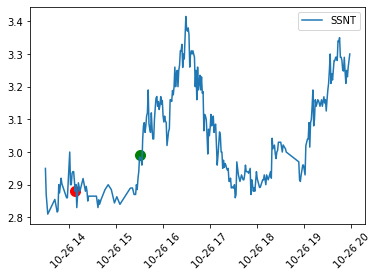

TECS analysis with profit -30.42


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,997.62,997.62,sell,2020-10-26 10:38:00-04:00,12.79,-78,1.43%,,"{'macd': [0.0413887443372829, 0.04117620608649908, 0.040984926850999415, 0.040308801123973836], 'reason': ['MACD positive & above signal, MACD hist trending down, MACD trended down'], 'hist_signal': [0.01142185059580551, 0.008967449876017351, 0.007020936512414151, 0.005075848628310856], 'macd_signal': [0.02996689374147739, 0.03220875621048173, 0.03396399033858526, 0.03523295249566298]}",11.35,13.17
1,-30.42,-1028.04,buy,2020-10-26 11:17:00-04:00,13.18,78,4.52%,,"{'reason': ['stopped'], 'close_5m': [13.05, 13.04, 13.11, 13.1495, 13.18]}",11.35,13.17


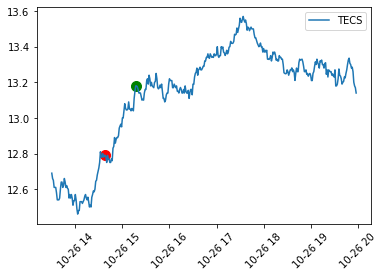

TWM analysis with profit -29.44


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,999.68,999.68,sell,2020-10-26 10:42:00-04:00,7.81,-128,0.64%,,"{'macd': [0.008997525752983293, 0.00848093125983862, 0.008227988391675822, 0.006885072021787231], 'reason': ['MACD positive & above signal, MACD hist trending down, MACD trended down'], 'hist_signal': [0.0009646807645337166, 0.00035846901711123445, 8.44209191587491e-05, -0.0010067963605838743], 'macd_signal': [0.008032844988449576, 0.008122462242727385, 0.008143567472517073, 0.007891868382371105]}",7.00,8.04
1,-29.44,-1029.12,buy,2020-10-26 13:26:00-04:00,8.04,128,3.61%,,"{'reason': ['stopped'], 'close_5m': [8.02, 8.0234, 8.03, 8.0299, 8.045]}",7.00,8.04


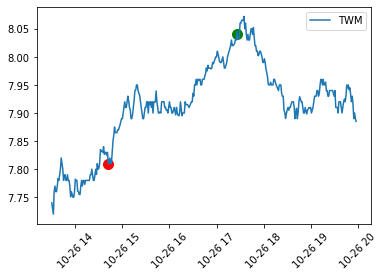

TZA analysis with profit -32.56


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,999.74,999.74,sell,2020-10-26 10:23:00-04:00,13.51,-74,0.37%,,"{'macd': [0.012318496644413202, 0.013473124407322956, 0.012753702866636019, 0.010469040589912382], 'reason': ['MACD positive & above signal, MACD hist trending down, MACD trended down'], 'hist_signal': [0.0017911480264610515, 0.002356620631496645, 0.001309759272647766, -0.0007799224032606963], 'macd_signal': [0.01052734861795215, 0.011116503775826311, 0.011443943593988253, 0.011248962993173078]}",12.14,13.92
1,-32.56,-1032.30,buy,2020-10-26 11:16:00-04:00,13.95,74,3.64%,,"{'reason': ['stopped'], 'close_5m': [13.815, 13.83, 13.851, 13.891, 13.9485]}",12.14,13.92


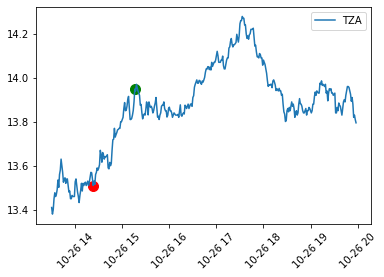

UVXY analysis with profit -31.92


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,987.28,987.28,sell,2020-10-26 10:40:00-04:00,17.63,-56,1.94%,,"{'macd': [0.07886122889077285, 0.08034585924231763, 0.07884887173388222, 0.07460642858790578], 'reason': ['MACD positive & above signal, MACD hist trending down, MACD trended down'], 'hist_signal': [0.016975399840815503, 0.014768024153888226, 0.01061682931636225, 0.005099508936308644], 'macd_signal': [0.06188582904995735, 0.0655778350884294, 0.06823204241751997, 0.06950691965159714]}",15.61,18.16
1,-31.92,-1019.20,buy,2020-10-26 11:00:00-04:00,18.20,56,5.23%,,"{'reason': ['stopped'], 'close_5m': [18.0601, 18.06, 18.1264, 18.13, 18.1999]}",15.61,18.16


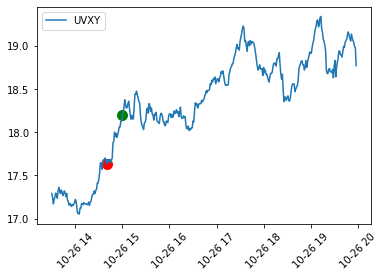

VIXY analysis with profit -30.21


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,998.52,998.52,sell,2020-10-26 10:40:00-04:00,18.84,-53,1.29%,,"{'macd': [0.05734663872466328, 0.05819696412034148, 0.05709076359593013, 0.053928909114624446], 'reason': ['MACD positive & above signal, MACD hist trending down, MACD trended down'], 'hist_signal': [0.012983417811605974, 0.01106699456582734, 0.007968635233132793, 0.003845424601461686], 'macd_signal': [0.044363220913057305, 0.04712996955451414, 0.049122128362797335, 0.05008348451316276]}",16.75,19.41
1,-30.21,-1028.73,buy,2020-10-26 11:16:00-04:00,19.41,53,4.35%,,"{'reason': ['stopped'], 'close_5m': [19.2595, 19.221, 19.22, 19.32, 19.41]}",16.75,19.41


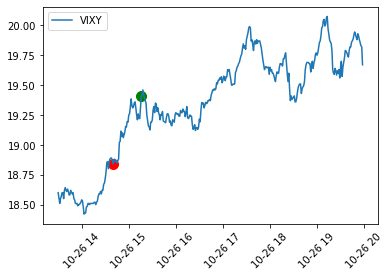

WEI analysis with profit 25.70


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,1002.30,1002.30,sell,2020-10-26 10:54:00-04:00,1.95,-514,9.55%,,"{'macd': [0.02157543432438258, 0.021586204592711544, 0.0184571138330627, 0.01655837929524462], 'reason': ['MACD positive & above signal, MACD hist trending down, MACD trended down'], 'hist_signal': [0.004628040571017712, 0.0037110486714773405, 0.0004655663294627979, -0.001146534566684225], 'macd_signal': [0.01694739375336487, 0.017875155921234204, 0.0179915475035999, 0.017704913861928843]}",1.72,2.00
1,25.70,-976.60,buy,2020-10-26 11:09:00-04:00,1.90,514,6.74%,,"{'reason': ['reversing direction'], 'close_5m': [1.87, 1.9, 1.88, 1.8927, 1.904]}",1.72,2.00


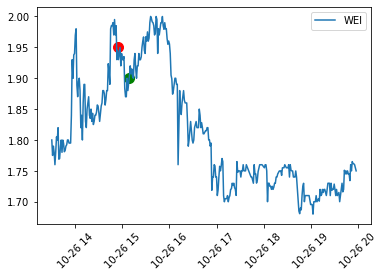

WTRH analysis with profit 6.50


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,997.75,997.75,sell,2020-10-26 10:00:00-04:00,3.07,-325,-0.65%,,"{'macd': [0.01605688219749135, 0.014712415889254427, 0.013213969208949461, 0.01083577739041397], 'reason': ['MACD positive & above signal, MACD hist trending down, MACD trended down'], 'hist_signal': [0.00644730238837995, 0.004082268864114421, 0.0020670577470475633, -0.00024890725719034154], 'macd_signal': [0.009609579809111401, 0.010630147025140006, 0.011146911461901898, 0.011084684647604311]}",2.77,3.16
1,6.50,-991.25,buy,2020-10-26 10:33:00-04:00,3.05,325,-1.29%,,"{'reason': ['reversing direction'], 'close_5m': [3.025, 3.04, 3.035, 3.035, 3.05]}",2.77,3.16


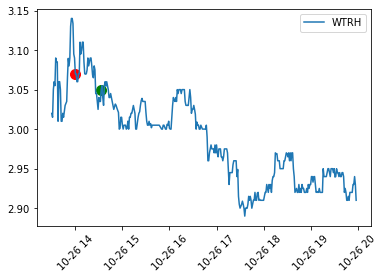

WWR analysis with profit -69.91


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,996.00,996.00,sell,2020-10-26 10:04:00-04:00,4.15,-240,4.81%,,"{'macd': [0.03572957385833497, 0.03427148255365697, 0.033162950594769036, 0.030876263995703646], 'reason': ['MACD positive & above signal, MACD hist trending down, MACD trended down'], 'hist_signal': [0.009680193455453685, 0.006577681720620548, 0.0043753198093860884, 0.0016709065682565596], 'macd_signal': [0.026049380402881288, 0.027693800833036426, 0.028787630785382948, 0.029205357427447086]}",3.66,4.27
1,-50.40,-1046.40,buy,2020-10-26 10:12:00-04:00,4.36,240,10.11%,,"{'reason': ['stopped'], 'close_5m': [4.26, 4.26, 4.22, 4.2512, 4.36]}",3.66,4.27
2,945.96,996.36,sell,2020-10-26 10:18:00-04:00,4.37,-228,10.37%,,"{'macd': [0.05951873390219209, 0.058630039065408646, 0.05726962699693683, 0.05390736269686869], 'reason': ['MACD positive & above signal, MACD hist trending down, MACD trended down'], 'hist_signal': [0.01659150677722407, 0.012562249552352502, 0.00896146998710455, 0.0044793645496291265], 'macd_signal': [0.04292722712496802, 0.046067789513056144, 0.04830815700983228, 0.04942799814723956]}",3.81,4.50
3,-48.12,-994.08,buy,2020-10-26 10:28:00-04:00,4.36,228,10.11%,,"{'reason': ['reversing direction'], 'close_5m': [4.27, 4.2499, 4.3077, 4.38, 4.355]}",3.81,4.50
4,947.16,995.28,sell,2020-10-26 10:36:00-04:00,4.29,-232,8.35%,,"{'macd': [0.024955062184437438, 0.025777614009476757, 0.0237513217431502, 0.01791588203246519], 'reason': ['MACD positive & above signal, MACD hist trending down, MACD trended down'], 'hist_signal': [0.0018600438903608983, 0.002146076572320174, 9.582744479489508e-05, -0.0045916898127120916], 'macd_signal': [0.02309501829407654, 0.023631537437156583, 0.023655494298355305, 0.022507571845177283]}",3.83,4.42
5,-85.24,-1032.40,buy,2020-10-26 10:41:00-04:00,4.45,232,12.39%,,"{'reason': ['stopped'], 'close_5m': [4.36, 4.33, 4.37, 4.36, 4.4499]}",3.83,4.42
6,913.40,998.64,sell,2020-10-26 10:58:00-04:00,4.56,-219,15.17%,,"{'macd': [0.05243358492426786, 0.05376692653873949, 0.049951778101460675, 0.04217436661654972], 'reason': ['MACD positive & above signal, MACD hist trending down, MACD trended down'], 'hist_signal': [0.005123265118039302, 0.005165285386008744, 0.0010801095589839452, -0.005357841540741606], 'macd_signal': [0.04731031980622856, 0.048601641152730746, 0.04887166854247673, 0.047532208157291325]}",3.95,4.70
7,-69.91,-983.31,buy,2020-10-26 11:10:00-04:00,4.49,219,13.4%,,"{'reason': ['reversing direction'], 'close_5m': [4.43, 4.4609, 4.44, 4.4839, 4.4898]}",3.95,4.70


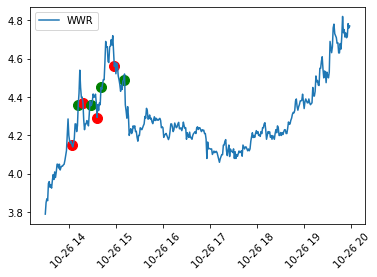

YRD analysis with profit 0.00


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,996.48,996.48,sell,2020-10-26 10:52:00-04:00,3.46,-288,0.58%,,"{'macd': [0.01701623017476539, 0.022658390871230782, 0.022090485038980034, 0.020581850818537806], 'reason': ['MACD positive & above signal, MACD hist trending down, MACD trended down'], 'hist_signal': [0.006707282973149575, 0.009879554935691974, 0.00744931928275298, 0.0047525480498486], 'macd_signal': [0.010308947201615815, 0.012778835935538808, 0.014641165756227054, 0.015829302768689206]}",3.08,3.57
1,0.00,-996.48,buy,2020-10-26 14:34:00-04:00,3.46,288,0.58%,,"{'reason': ['reversing direction'], 'close_5m': [3.46, 3.45, 3.44, 3.44, 3.46]}",3.08,3.57


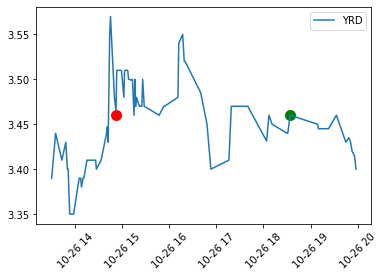

In [11]:
for symbol in minute_history:
    symbol_df = trades.loc[trades["symbol"] == symbol]
    start_date = symbol_df["client_time"].min()
    start_date = start_date.replace(hour=9, minute=30)
    end_date = start_date.replace(hour=16, minute=0)
    cool_down_date = start_date + timedelta(minutes=5)
    minute_history_index = minute_history[symbol]["close"].index.get_loc(
        start_date, method="nearest"
    )
    end_index = minute_history[symbol]["close"].index.get_loc(
        end_date, method="nearest"
    )
    cool_minute_history_index = minute_history[symbol]["close"].index.get_loc(
        cool_down_date, method="nearest"
    )
    open_price = minute_history[symbol]["close"][cool_minute_history_index]
    plt.plot(
        minute_history[symbol]["close"][minute_history_index:end_index].between_time(
            "9:30", "16:00"
        ),
        label=symbol,
    )
    plt.xticks(rotation=45)

    delta = 0
    profit = 0

    operations = []
    deltas = []
    profits = []
    times = []
    prices = []
    qtys = []
    indicators = []
    target_price = []
    stop_price = []
    daily_change = []
    precent_vwap = []
    patterns = []
    for index, row in symbol_df.iterrows():
        if (
            row["operation"] == "buy"
            and row["qty"] > 0
            or row["operation"] == "sell"
            and row["qty"] < 0
        ):
            try:
                now = int(row["client_time"])
                continue
            except Exception:
                pass

        delta = (
            row["price"]
            * row["qty"]
            * (1 if row["operation"] == "sell" and row["qty"] > 0 else -1)
        )
        profit += delta
        plt.scatter(
            row["client_time"].to_pydatetime(),
            row["price"],
            c="g" if row["operation"] == "buy" else "r",
            s=100,
        )
        deltas.append(round(delta, 2))
        profits.append(round(profit, 2))
        operations.append(row["operation"])
        times.append(pd.to_datetime(row["client_time"]))
        prices.append(row["price"])
        qtys.append(row["qty"])
        indicator = json.loads(row.indicators)
        indicators.append(indicator)
        target_price.append(row["target_price"])
        stop_price.append(row["stop_price"])
        daily_change.append(
            f"{round(100.0 * (float(row['price']) - open_price) / open_price, 2)}%"
        )
        precent_vwap.append(
            f"{round(100.0 * (indicator['buy']['avg'] - open_price) / open_price, 2)}%"
            if 'buy' in indicator and indicator['buy'] and "avg" in indicator['buy']
            else ""
        )

    d = {
        "profit": profits,
        "trade": deltas,
        "operation": operations,
        "at": times,
        "price": prices,
        "qty": qtys,
        "daily change": daily_change,
        "vwap": precent_vwap,
        "indicators": indicators,
        "target price": target_price,
        "stop price": stop_price,
    }
    print(f"{symbol} analysis with profit {round(profit, 2)}")
    display(HTML(pd.DataFrame(data=d).to_html()))
    plt.legend()
    plt.show()